Another attempt at visualizing and classifying frequenciess lesss goooo

In [1]:
import mne
from mne.preprocessing import ICA
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
from scipy.signal import convolve
from scipy.ndimage import convolve1d
import sklearn
import h5py

In [2]:
subject1 = sc.io.loadmat("../data/s3.mat")
data1 = subject1['eeg']
data1 = data1.transpose(0,3,1,2)
data1 *= 1e-6

[n_target_freq * n_channels * points * n_trials] -> [n_target_freq * n_trials * n_channel * n_points]

In [3]:
srate = 256
n_targets = 12
n_channels = 8
n_points = 1114
n_trials = 15
points = np.arange(0, n_points)

target_freq = [9.25, 11.25, 13.25, 9.75, 11.75, 13.75, 10.25, 12.25, 14.25, 10.75, 12.75, 14.75]

#For IIR Butterworth Bandpass filtering
tmin = 0.15
tmax = 4
fmin = 6
fmax = 60.0

In [4]:
subject1data : list[mne.EpochsArray] = []
iir_params = dict(order=4, ftype='butter')

for i in range(n_targets):
    epoched_data = mne.EpochsArray(
        data1[i,:,:,:],
        info = mne.create_info(n_channels, srate, ch_types='eeg'),
        verbose=False
        )
    subject1data.append(epoched_data.filter(l_freq = fmin, h_freq = fmax, method = 'iir', iir_params = iir_params, verbose = False))

In [5]:
all_trial_psd = [data.compute_psd("welch", window = 'boxcar', verbose=False, tmin=tmin, tmax = tmax, fmin = fmin, fmax = fmax) for data in subject1data]

In [6]:
mean_psd = [data.average() for data in all_trial_psd]

Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).


C:\Users\akila\AppData\Local\Temp\ipykernel_20352\1712216132.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mean_psd[i].plot(axes = axes[i])
c:\Users\akila\AppData\Local\Programs\Python\Python314\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
C:\Users\akila\AppData\Local\Temp\ipykernel_20352\1712216132.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mean_psd[i].plot(axes = axes[i])
C:\Users\akila\AppData\Local\Temp\ipykernel_20352\1712216132.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mean_psd[i].plot(axes = axes[i])
C:\Users\akila\AppData\Local\Temp\ipykernel_20352\1712216132.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mean_psd[i].plot(axes = axes[i])
C:\Users\akila\AppData\Local\Temp\ipykernel_20352\1712216132.py:3: RuntimeWarning: Channel lo

Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).


C:\Users\akila\AppData\Local\Temp\ipykernel_20352\1712216132.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mean_psd[i].plot(axes = axes[i])
C:\Users\akila\AppData\Local\Temp\ipykernel_20352\1712216132.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mean_psd[i].plot(axes = axes[i])
C:\Users\akila\AppData\Local\Temp\ipykernel_20352\1712216132.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mean_psd[i].plot(axes = axes[i])
C:\Users\akila\AppData\Local\Temp\ipykernel_20352\1712216132.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mean_psd[i].plot(axes = axes[i])
C:\Users\akila\AppData\Local\Temp\ipykernel_20352\1712216132.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mean_psd[i].plot(axes = axes[i])
C:\Users\akila\AppData\Local\Temp\ipykernel_20352\1712216132.py:3: RuntimeWarning: Channel locations not available.

Plotting power spectral density (dB=True).


C:\Users\akila\AppData\Local\Temp\ipykernel_20352\1712216132.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mean_psd[i].plot(axes = axes[i])


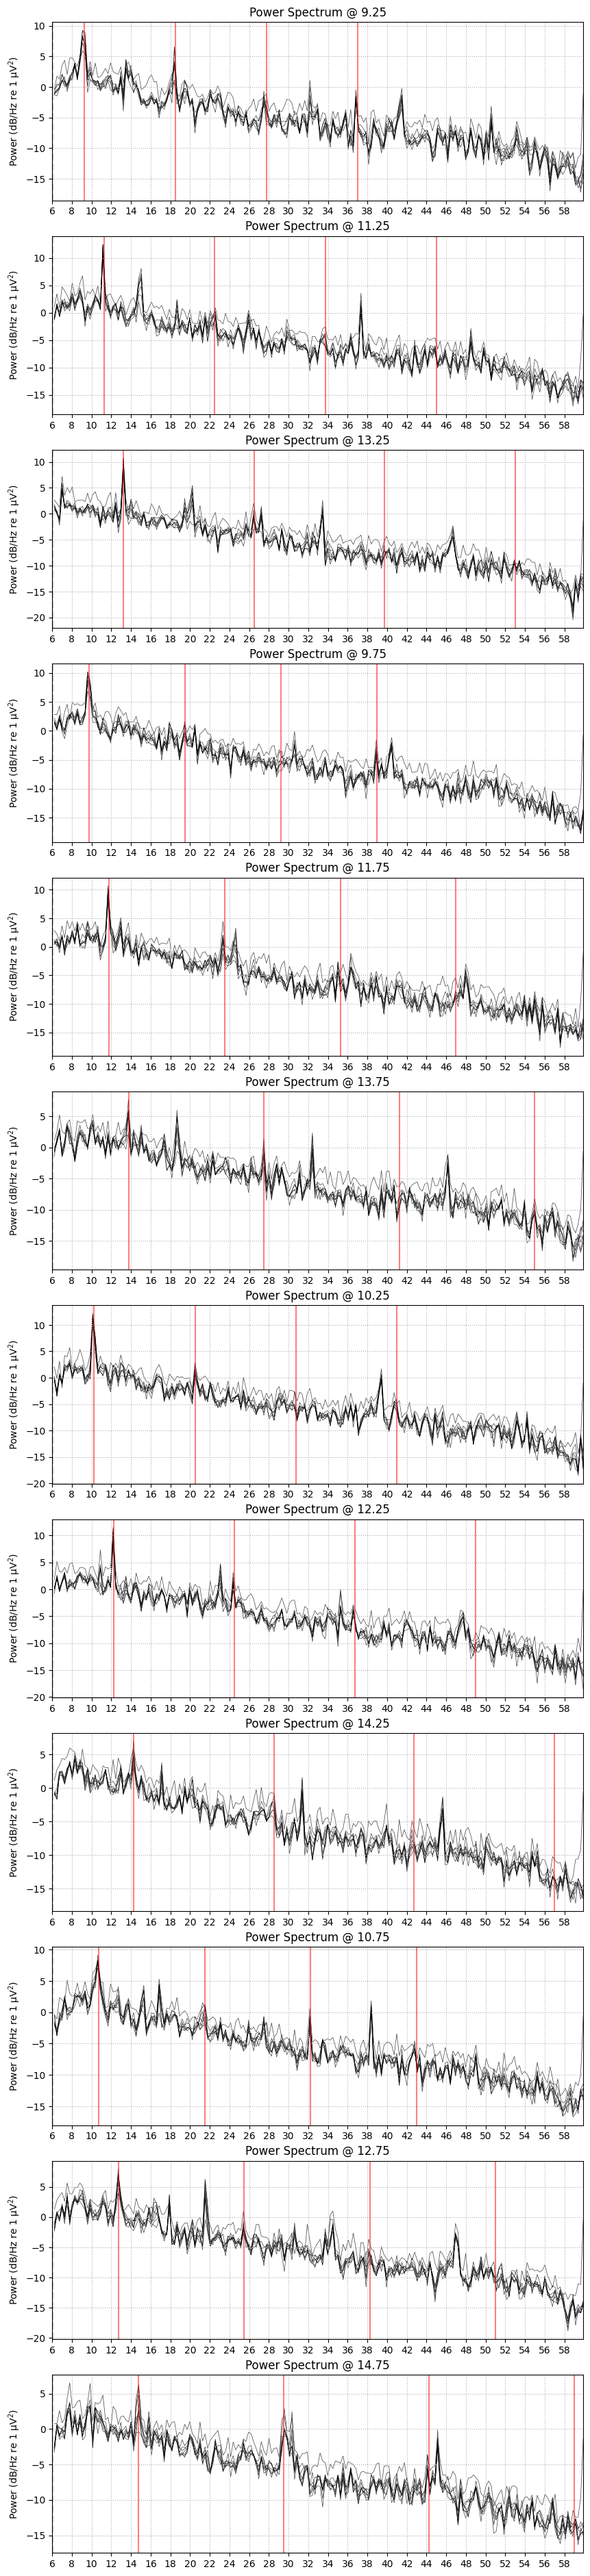

In [7]:
fig, axes = plt.subplots(n_targets, 1, figsize=(10, 4 * n_targets))
for i in range(n_targets):
    mean_psd[i].plot(axes = axes[i])
    axes[i].set_title(f"Power Spectrum @ {target_freq[i]}")
    axes[i].set_xticks(np.arange(6, 60, 2))
    
    for k in range(5):
        axes[i].axvline(x = target_freq[i] * k, color = 'r', alpha = 0.5)

In [8]:
def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """Compute SNR spectrum from PSD spectrum using convolution.

    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate(
        (
            np.ones(noise_n_neighbor_freqs),
            np.zeros(2 * noise_skip_neighbor_freqs + 1),
            np.ones(noise_n_neighbor_freqs),
        )
    )
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode="valid"), axis=-1, arr=psd
    )

    # The mean is not defined on the edges so we will pad it with nas. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(mean_noise, pad_width=pad_width, constant_values=np.nan)

    return psd / mean_noise

In [98]:
snr = [snr_spectrum(psd.get_data(), 3, 1) for psd in mean_psd]

8.85576923076923
10.932692307692308
13.009615384615385
9.375
11.451923076923077
18.461538461538463
9.89423076923077
11.971153846153847
31.18269230769231
38.19230769230769
12.490384615384617
44.94230769230769


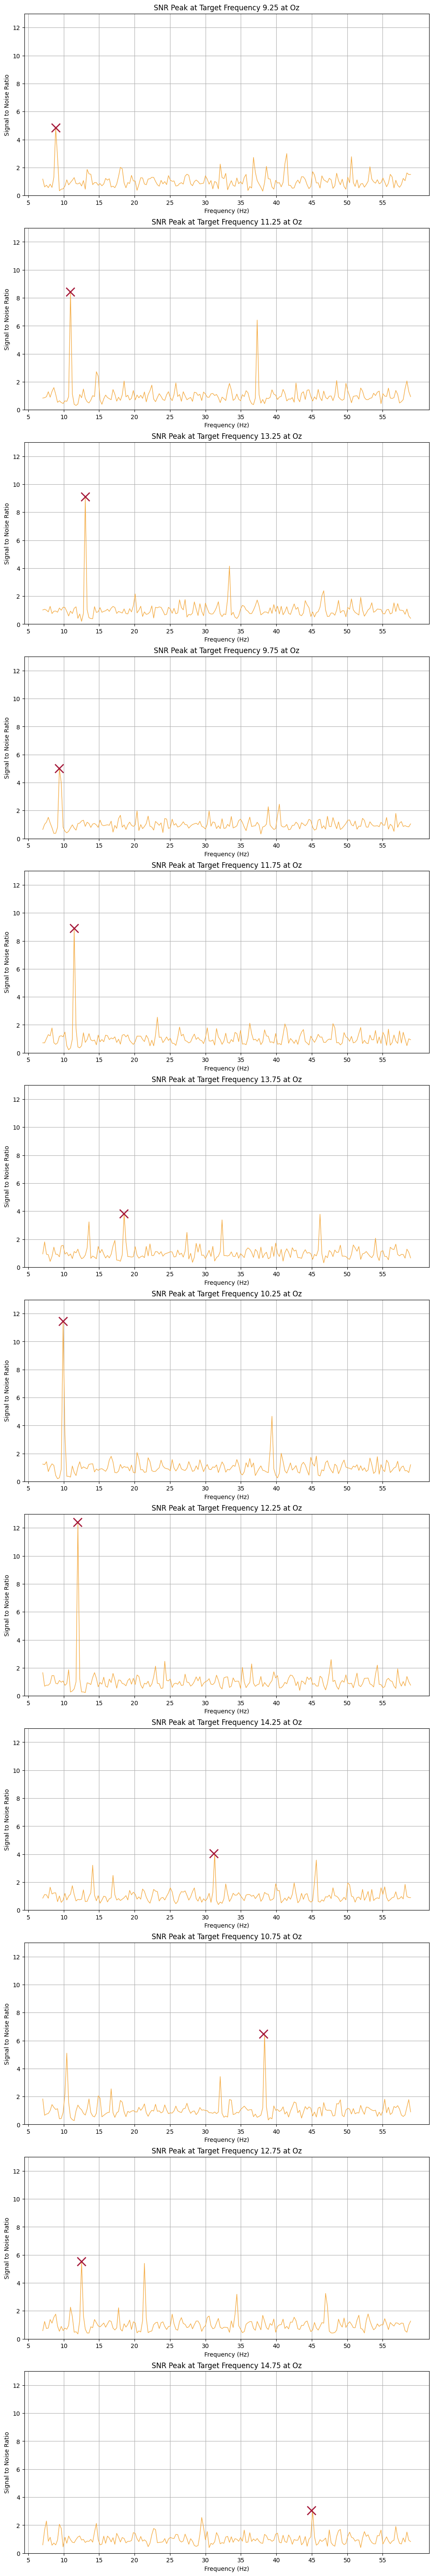

In [99]:
fig, axes = plt.subplots(n_targets, 1, figsize = (10, 5*n_targets), layout = "constrained")
for i in range(n_targets):
    axes[i].plot(np.linspace(6,60, len(snr[i][7])), snr[i][7], linewidth = 1, color = '#F4AC45')
    axes[i].set_xlabel("Frequency (Hz)")
    axes[i].set_ylabel("Signal to Noise Ratio")
    axes[i].set_title(f"SNR Peak at Target Frequency {target_freq[i]} at Oz")
    axes[i].set_ylim(0, 13)
    axes[i].set_xticks(np.arange(0,60,5))
    axes[i].grid(True)
    print((54/208)*np.argmax(np.nan_to_num(snr[i][7])) + 6)
    axes[i].plot((54/208)*np.argmax(np.nan_to_num(snr[i][7])) + 6, np.max(np.nan_to_num(snr[i][7])), 'x', markersize = 15, mec = "#A61C3C", mew = 2)

Check accuracy

In [ ]:
import pandas as pd
import numpy as np

results = []

for i in range(n_targets):
    peak_idx = np.argmax(np.nan_to_num(snr[i][7]))
    predicted_freq = (54/208) * peak_idx + 6.25

    actual_freq = target_freq[i]
    diff = predicted_freq - actual_freq
    rel_error = diff / actual_freq
    accuracy = 100 - abs(rel_error * 100)
    
    results.append({
        "Index": i,
        "Frequency": actual_freq,
        "Predicted Frequency": predicted_freq,
        "Difference": diff,
        "Relative Error": rel_error,
        "Accuracy": accuracy
    })

df = pd.DataFrame(results)

df.to_csv("../predictions/ssvep_results.csv", index=False, float_format='%.4f')

print("Data saved to 'ssvep_results.csv'")
print(df.head())

Data saved to 'ssvep_results.csv'
   Index  Frequency  Predicted Frequency  Difference  Relative Error  \
0      0       9.25             9.105769   -0.144231       -0.015593   
1      1      11.25            11.182692   -0.067308       -0.005983   
2      2      13.25            13.259615    0.009615        0.000726   
3      3       9.75             9.625000   -0.125000       -0.012821   
4      4      11.75            11.701923   -0.048077       -0.004092   

    Accuracy  
0  98.440748  
1  99.401709  
2  99.927431  
3  98.717949  
4  99.590835  
